In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# PCG Model

In [61]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

In [62]:
X_train = pd.read_csv('/content/drive/MyDrive/ML Project (PCG)/Train_pcg_X.csv')
y_train = pd.read_csv('/content/drive/MyDrive/ML Project (PCG)/Train_pcg_y.csv')
X_test = pd.read_csv('/content/drive/MyDrive/ML Project (PCG)/Test_pcg_X.csv')
y_test = pd.read_csv('/content/drive/MyDrive/ML Project (PCG)/Test_pcg_y.csv')

X_combined = pd.concat([X_train, X_test], axis=0)
y_combined = pd.concat([y_train, y_test], axis=0)

# Reset index
X_combined.reset_index(drop=True, inplace=True)
y_combined.reset_index(drop=True, inplace=True)

In [68]:
# Sequential Forward Selection
sfs = SFS(RandomForestClassifier(n_estimators=100, random_state=42),
          k_features=7)
sfs = sfs.fit(X_combined, y_combined.values.ravel())
sfs.k_feature_names_

('MEAN', 'RM_MIN', 'ZCR_GLOBAL', 'PEAK_AMP', 'SB_MEAN', 'CA_MEAN', 'CD_MEDIAN')

In [69]:
# Sequential Backward Selection
SBS = SFS(RandomForestClassifier(n_estimators=100, random_state=42),
          k_features=7, forward = False)
SBS = SBS.fit(X_combined, y_combined.values.ravel())
SBS.k_feature_names_

('MEAN', 'RM_MIN', 'ZCR_GLOBAL', 'PEAK_AMP', 'SB_MEAN', 'CA_MEAN', 'CD_MEDIAN')

In [63]:
# Use only selected features
selected_features =  ['MEAN', 'RM_MIN', 'ZCR_GLOBAL', 'PEAK_AMP', 'SB_MEAN', 'CA_MEAN', 'CD_MEDIAN']
X_combined = X_combined[selected_features]

# Encode labels to integers
le = LabelEncoder()
y_encoded = le.fit_transform(y_combined)  # HIGH, Medium, Low -> 0,1,2 (for example)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [74]:
# Define models
models = {
    'RandomForest': RandomForestClassifier(),
    'SVM': SVC(),
    'KNN': KNeighborsClassifier()
}

# Define hyperparameter grids
param_grids = {
    'RandomForest': {'n_estimators': [50, 100, 200], 'max_depth': [10, 20, None]},
    'SVM': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
    'KNN': {'n_neighbors': [3, 5, 7]}
}

# Loop through models and perform Grid Search
best_params = {}
for model_name, model in models.items():
    grid_search = GridSearchCV(model, param_grids[model_name], cv=5, scoring='accuracy')
    grid_search.fit(X_combined, y_combined.values.ravel())
    best_params[model_name] = grid_search.best_params_

print(best_params)


{'RandomForest': {'max_depth': 20, 'n_estimators': 50}, 'SVM': {'C': 1, 'kernel': 'linear'}, 'KNN': {'n_neighbors': 5}}


In [64]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

In [77]:
# Random Forest
rf_clf = RandomForestClassifier(max_depth=20, n_estimators=50, random_state=42)
rf_clf.fit(X_train, y_train)
rf_preds = rf_clf.predict(X_test)
rf_acc = accuracy_score(y_test, rf_preds)
print(f'Random Forest Accuracy: {rf_acc:.2f}')

Random Forest Accuracy: 0.80


In [78]:
# SVM
svm_clf = SVC(C=1, kernel='linear', random_state=4)
svm_clf.fit(X_train, y_train)
svm_preds = svm_clf.predict(X_test)
svm_acc = accuracy_score(y_test, svm_preds)
print(f'SVM Accuracy: {svm_acc:.2f}')

SVM Accuracy: 0.50


In [79]:
# KNN
knn_clf = KNeighborsClassifier(n_neighbors=3)
knn_clf.fit(X_train, y_train)
knn_preds = knn_clf.predict(X_test)
knn_acc = accuracy_score(y_test, knn_preds)
print(f'KNN Accuracy: {knn_acc:.2f}')

KNN Accuracy: 0.67


Text(0.5, 1.0, 'SVM Confusion Matrix')

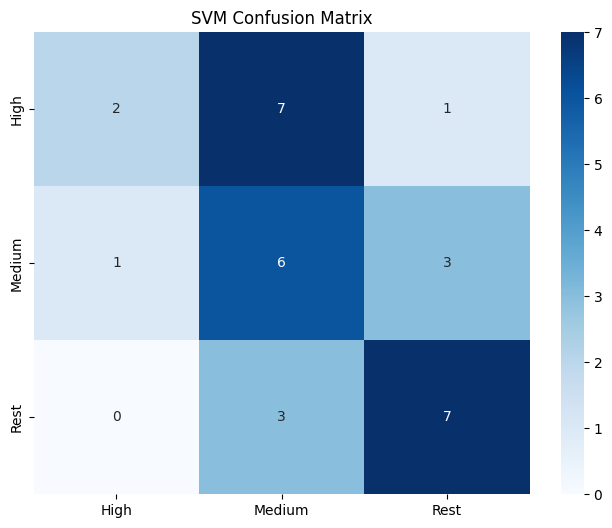

In [84]:
# RF confusion matrix
cm_rf = confusion_matrix(y_test, svm_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('SVM Confusion Matrix')

Text(0.5, 1.0, 'KNN Confusion Matrix')

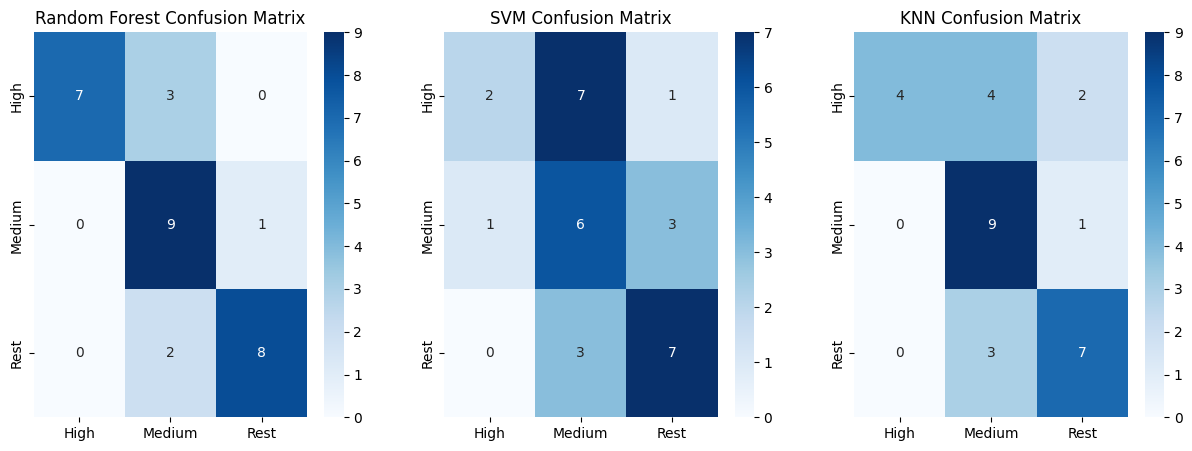

In [82]:
# Plot 3 Confusion Matrices
cm_rf = confusion_matrix(y_test, rf_preds)
cm_svm = confusion_matrix(y_test, svm_preds)
cm_knn = confusion_matrix(y_test, knn_preds)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axs[0], xticklabels=le.classes_, yticklabels=le.classes_)
axs[0].set_title('Random Forest Confusion Matrix')

sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', ax=axs[1], xticklabels=le.classes_, yticklabels=le.classes_)
axs[1].set_title('SVM Confusion Matrix')

sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', ax=axs[2], xticklabels=le.classes_, yticklabels=le.classes_)
axs[2].set_title('KNN Confusion Matrix')

# IGNORE

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
train_X = pd.read_csv('/content/drive/MyDrive/ML Project (PCG)/Train_pcg_X.csv')
train_y = pd.read_csv('/content/drive/MyDrive/ML Project (PCG)/Train_pcg_y.csv')
test_X = pd.read_csv('/content/drive/MyDrive/ML Project (PCG)/Test_pcg_X.csv')
test_y = pd.read_csv('/content/drive/MyDrive/ML Project (PCG)/Test_pcg_y.csv')


In [ ]:
train_X.head()

,MEAN,STD,ENERGY,POWER,AE_MEDIAN,RM_MIN,ZCR_GLOBAL,ZCR_MAX,PEAK_AMP,PEAK_FREQ,...,DELTA1_MEDIAN,DELTA1_STD,DELTA2_MEAN,DELTA2_MEDIAN,CA_MEAN,CA_MEDIAN,CD_MIN,CD_MEAN,CD_MEDIAN,CD_STD
0,0.430983,0.596186,0.382384,0.382384,0.467531,0.353035,0.793099,0.742194,0.365551,0.304578,...,0.308288,0.456553,0.550458,0.417596,0.430924,0.399806,0.539056,0.052427,0.247277,0.301989
1,0.156740,0.428703,0.206853,0.206853,0.357176,0.404880,0.525813,0.680350,0.201159,0.876830,...,0.445233,0.141529,0.592429,0.710600,0.156739,0.396336,0.962503,0.607633,0.908707,0.076848
2,0.519970,0.841029,0.723337,0.723337,0.666721,0.438871,0.197395,0.463302,0.881168,0.017284,...,0.755409,0.266773,0.951635,0.447793,0.519897,0.240157,0.677959,0.091123,0.414842,0.169974
3,0.161902,0.574294,0.356781,0.356781,0.523935,0.639725,0.272078,0.445465,0.658242,0.104329,...,0.415415,0.204326,0.661746,0.751349,0.161890,0.496905,0.000000,0.000000,0.933619,0.231633
4,0.475599,0.285268,0.093754,0.093754,0.241327,0.178963,0.534147,0.599508,0.034359,0.444254,...,0.791187,0.196865,0.483854,0.288845,0.475592,0.392074,0.658072,0.719466,0.500538,0.026418


In [ ]:
print(train_X.columns)
len(train_X.columns)

Index(['MEAN', 'STD', 'ENERGY', 'POWER', 'AE_MEDIAN', 'RM_MIN', 'ZCR_GLOBAL',
       'ZCR_MAX', 'PEAK_AMP', 'PEAK_FREQ', 'BER_MIN', 'SB_MAX', 'SB_MEAN',
       'SB_STD', 'MFCC_MAX', 'MFCC_MEDIAN', 'DELTA1_MIN', 'DELTA1_MEAN',
       'DELTA1_MEDIAN', 'DELTA1_STD', 'DELTA2_MEAN', 'DELTA2_MEDIAN',
       'CA_MEAN', 'CA_MEDIAN', 'CD_MIN', 'CD_MEAN', 'CD_MEDIAN', 'CD_STD'],
      dtype='object')


28

In [ ]:
print(test_X.columns)
len(test_X.columns)

Index(['MEAN', 'STD', 'ENERGY', 'POWER', 'AE_MEDIAN', 'RM_MIN', 'ZCR_MAX',
       'ZCR_MIN', 'ZCR_GLOBAL', 'PEAK_AMP', 'PEAK_FREQ', 'BER_MIN', 'SB_MAX',
       'SB_MEAN', 'SB_STD', 'MFCC_MAX', 'MFCC_MEDIAN', 'DELTA1_MIN',
       'DELTA1_MEAN', 'DELTA1_MEDIAN', 'DELTA1_STD', 'DELTA2_MEAN',
       'DELTA2_MEDIAN', 'CA_MEAN', 'CA_MEDIAN', 'CD_MIN', 'CD_MEAN',
       'CD_MEDIAN', 'CD_STD'],
      dtype='object')


29

In [ ]:
test_X = test_X.drop(columns=['ZCR_MIN'])

In [ ]:
train_y.head()

,Stress_Level
0,Rest
1,High
2,Medium
3,High
4,Rest


In [ ]:
train_X = train_X.reindex(sorted(train_X.columns), axis=1)
test_X = test_X.reindex(sorted(test_X.columns), axis=1)

In [ ]:
test_y.head()

,Stress_Level
0,High
1,Medium
2,High
3,High
4,Medium


In [ ]:
rf = RandomForestClassifier(max_depth=10, min_samples_split=2, n_estimators=200, random_state=42)
# rf = RandomForestClassifier(max_depth=10, min_samples_split=2, n_estimators=200, random_state=42)
rf.fit(train_X, train_y.values.ravel())
rf_preds = rf.predict(test_X)
rf_acc = accuracy_score(test_y, rf_preds)
print(f'Random Forest Accuracy: {rf_acc:.2f}')

# Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}

Random Forest Accuracy: 0.38


In [ ]:
svm = SVC(random_state=42)
svm.fit(train_X, train_y.values.ravel())
svm_preds = svm.predict(test_X)
svm_acc = accuracy_score(test_y, svm_preds)
print(f'SVM Accuracy: {svm_acc:.2f}')

SVM Accuracy: 0.50



Random Forest Classification Report:
              precision    recall  f1-score   support

        High       0.00      0.00      0.00         4
      Medium       0.25      1.00      0.40         2
        Rest       0.00      0.00      0.00         2

    accuracy                           0.25         8
   macro avg       0.08      0.33      0.13         8
weighted avg       0.06      0.25      0.10         8



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


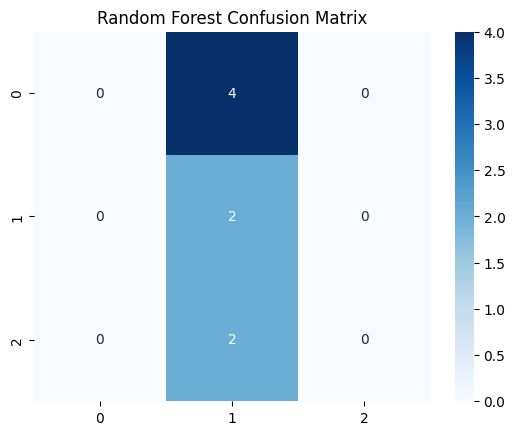


SVM Classification Report:
              precision    recall  f1-score   support

        High       0.50      1.00      0.67         4
      Medium       0.00      0.00      0.00         2
        Rest       0.00      0.00      0.00         2

    accuracy                           0.50         8
   macro avg       0.17      0.33      0.22         8
weighted avg       0.25      0.50      0.33         8



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


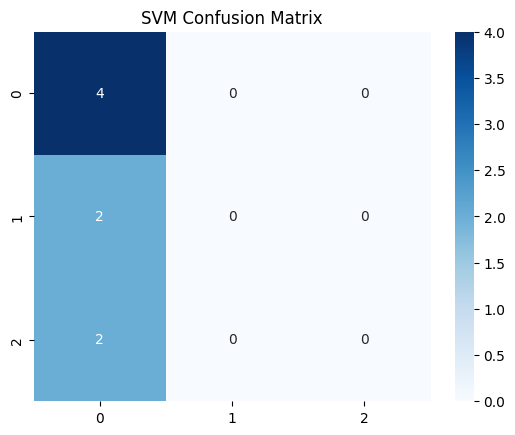

In [ ]:
def evaluate_model(name, y_true, y_pred):
    print(f'\n{name} Classification Report:')
    print(classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} Confusion Matrix')
    plt.show()

# Evaluating all models
evaluate_model('Random Forest', test_y, rf_preds)
evaluate_model('SVM', test_y, svm_preds)

In [ ]:
cv_scores = cross_val_score(rf, train_X, train_y.values.ravel(), cv=5)
print(f'Random Forest CV Accuracy: {np.mean(cv_scores):.2f} ± {np.std(cv_scores):.2f}')

Random Forest CV Accuracy: 0.81 ± 0.12


In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
}
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(train_X, train_y.values.ravel())
print(f'Best Parameters: {grid_search.best_params_}')
print(f'Best CV Score: {grid_search.best_score_:.2f}')

Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
Best CV Score: 0.83


In [ ]:
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto', 0.1, 1],
}

grid_search_svm = GridSearchCV(svm, param_grid_svm, cv=5, scoring='accuracy')
grid_search_svm.fit(train_X, train_y.values.ravel())
print(f'Best Parameters: {grid_search_svm.best_params_}')
print(f'Best CV Score: {grid_search_svm.best_score_:.2f}')

Best Parameters: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Best CV Score: 0.87


In [ ]:
svm_model = SVC(C=10, gamma=0.1, kernel='rbf', random_state=42)
svm_model.fit(train_X, train_y.values.ravel())
svm_preds = svm_model.predict(test_X)
svm_acc = accuracy_score(test_y, svm_preds)
print(f'SVM Accuracy: {svm_acc:.2f}')

SVM Accuracy: 0.50


In [ ]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5)
cv_scores = cross_val_score(rf, train_X, train_y.values.ravel(), cv=skf, scoring='accuracy')
print(f'Stratified CV Accuracy: {np.mean(cv_scores):.2f} ± {np.std(cv_scores):.2f}')


Stratified CV Accuracy: 0.83 ± 0.12


In [ ]:
best_rf = RandomForestClassifier(**grid_search.best_params_, random_state=42)
best_rf.fit(train_X, train_y.values.ravel())
best_rf_preds = best_rf.predict(test_X)
print(f'Accuracy with Best Parameters: {accuracy_score(test_y, best_rf_preds):.2f}')


Accuracy with Best Params: 0.38


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Missing values in train_X: 0
Missing values in test_X: 0
Selected Features: Index(['AE_MEDIAN', 'CA_MEAN', 'CA_MEDIAN', 'CD_MEAN', 'CD_MEDIAN', 'CD_MIN',
       'DELTA1_STD', 'DELTA2_MEDIAN', 'MEAN', 'PEAK_AMP', 'RM_MIN', 'SB_MAX',
       'SB_MEAN', 'SB_STD', 'ZCR_GLOBAL'],
      dtype='object')


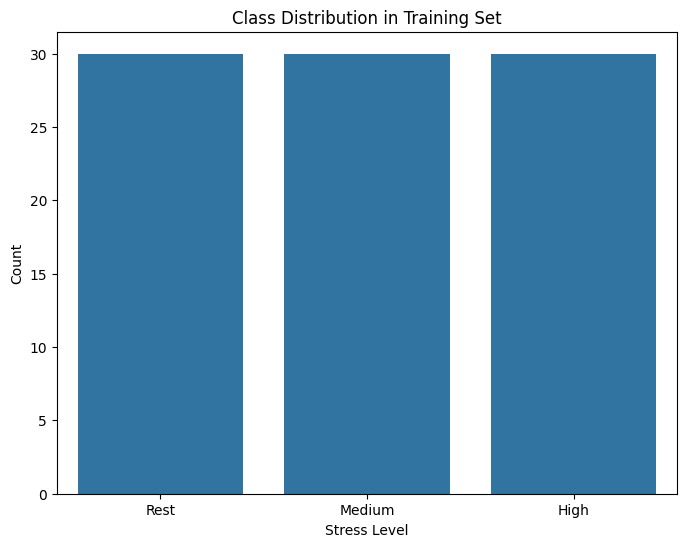

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
405 fits failed out of a total of 810.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
405 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/util

Best Random Forest Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Random Forest CV Score: 0.84
Best SVM Parameters: {'C': 10, 'class_weight': None, 'gamma': 0.1, 'kernel': 'rbf'}
Best SVM CV Score: 0.86
Random Forest Test Accuracy: 0.25
Random Forest Classification Report:
               precision    recall  f1-score   support

        High       0.00      0.00      0.00         4
      Medium       0.00      0.00      0.00         2
        Rest       0.25      1.00      0.40         2

    accuracy                           0.25         8
   macro avg       0.08      0.33      0.13         8
weighted avg       0.06      0.25      0.10         8



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


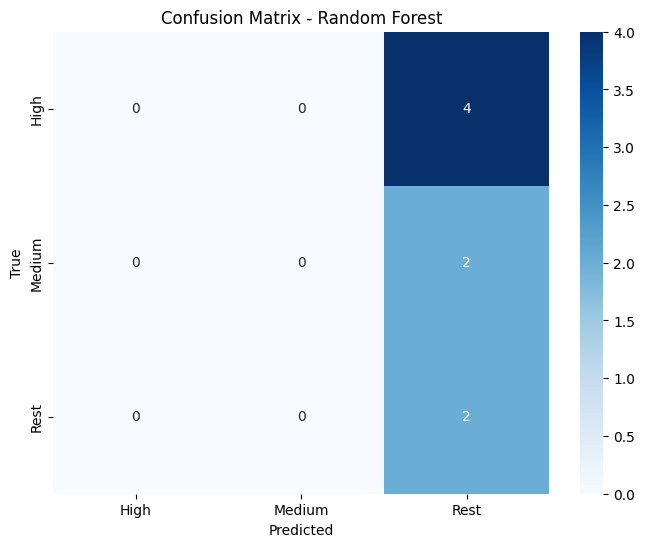

SVM Test Accuracy: 0.50
SVM Classification Report:
               precision    recall  f1-score   support

        High       0.50      1.00      0.67         4
      Medium       0.00      0.00      0.00         2
        Rest       0.00      0.00      0.00         2

    accuracy                           0.50         8
   macro avg       0.17      0.33      0.22         8
weighted avg       0.25      0.50      0.33         8



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


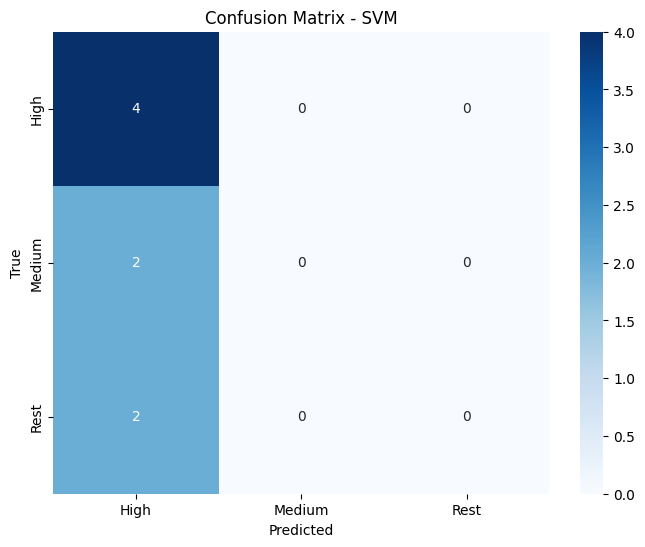

Ensemble Test Accuracy: 0.38
Ensemble Classification Report:
               precision    recall  f1-score   support

        High       0.50      0.50      0.50         4
      Medium       0.25      0.50      0.33         2
        Rest       0.00      0.00      0.00         2

    accuracy                           0.38         8
   macro avg       0.25      0.33      0.28         8
weighted avg       0.31      0.38      0.33         8



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


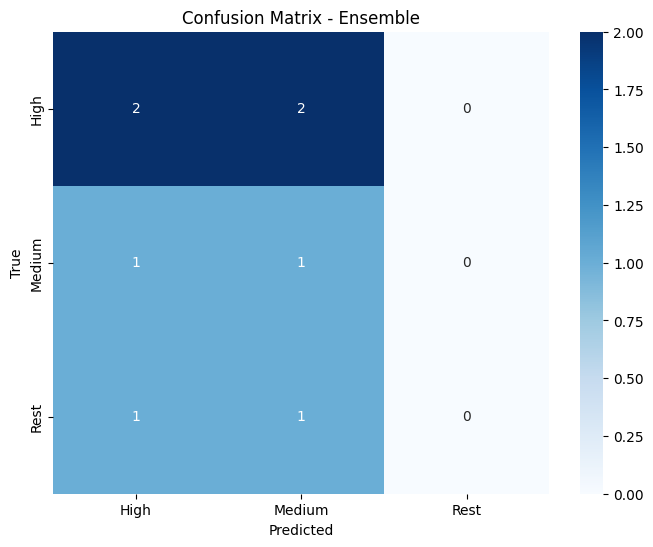

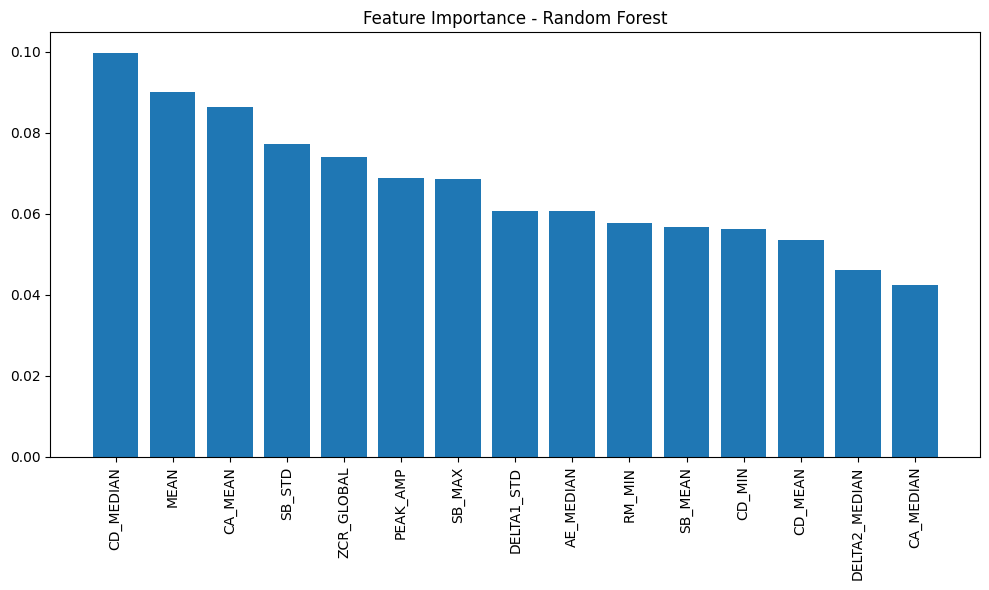

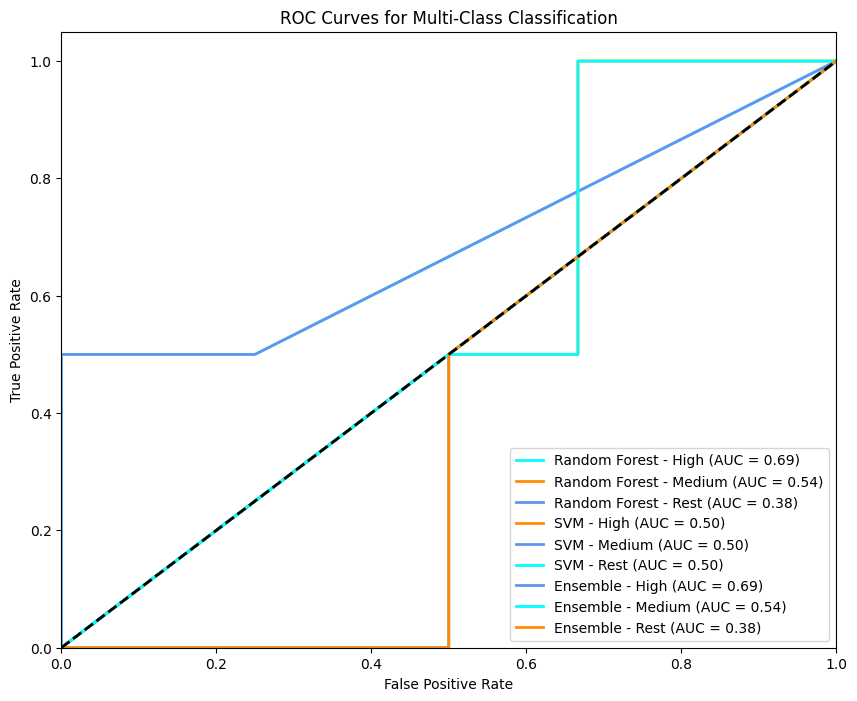

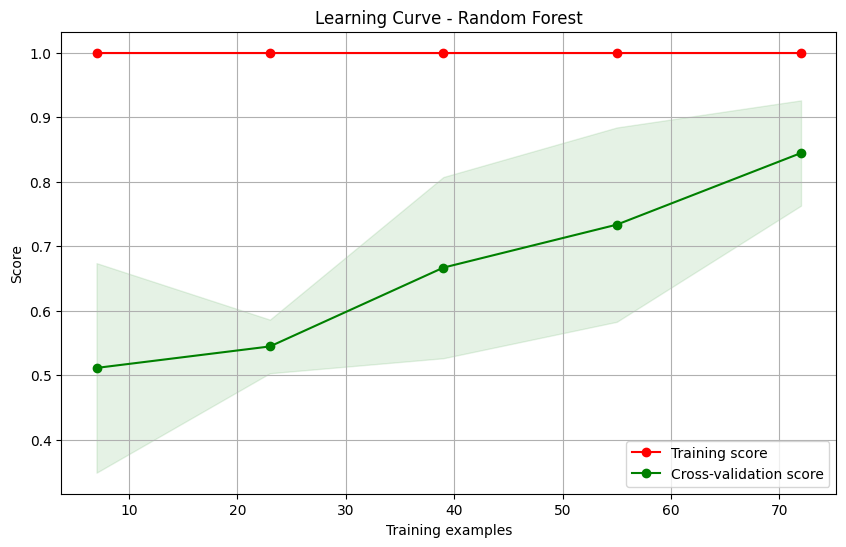

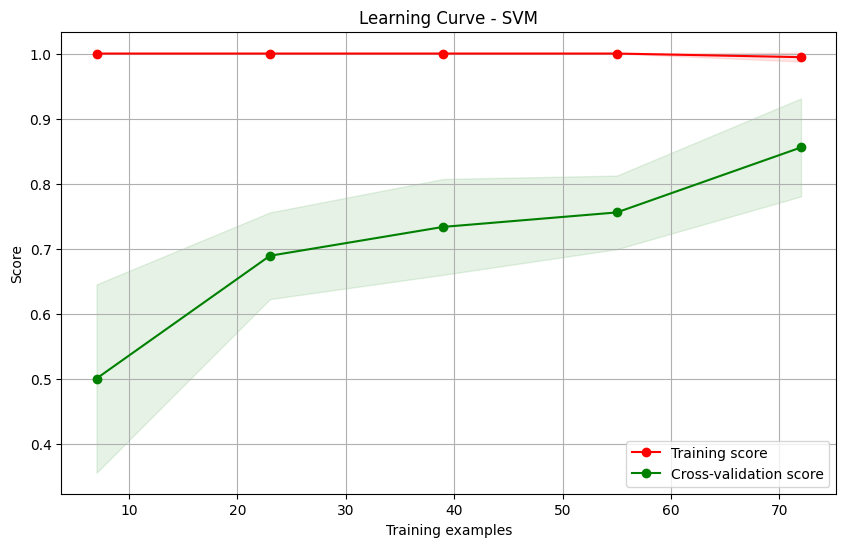

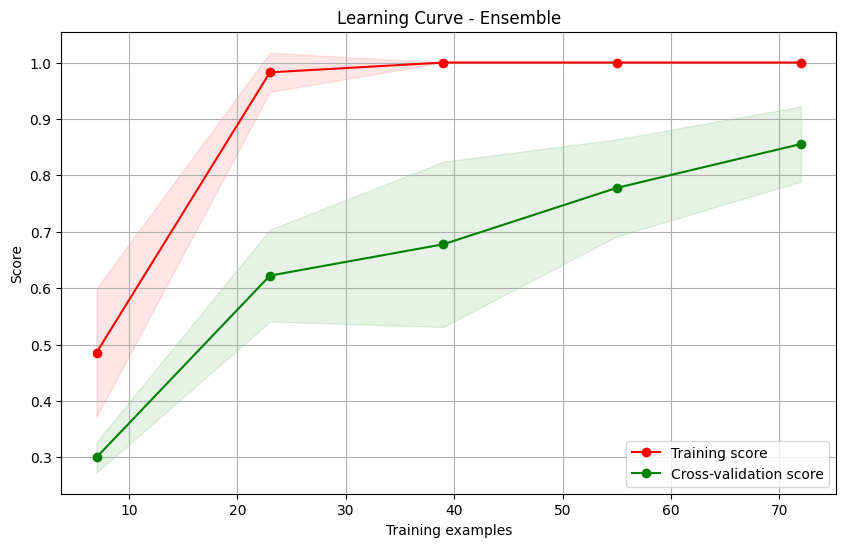

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Load datasets
train_X = pd.read_csv('/content/drive/MyDrive/ML Project (PCG)/Train_pcg_X.csv')
train_y = pd.read_csv('/content/drive/MyDrive/ML Project (PCG)/Train_pcg_y.csv')
test_X = pd.read_csv('/content/drive/MyDrive/ML Project (PCG)/Test_pcg_X.csv')
test_y = pd.read_csv('/content/drive/MyDrive/ML Project (PCG)/Test_pcg_y.csv')

# Drop inconsistent column in test_X
test_X = test_X.drop(columns=['ZCR_MIN'])

train_X = train_X.reindex(sorted(train_X.columns), axis=1)
test_X = test_X.reindex(sorted(test_X.columns), axis=1)

# Check for missing values
print("Missing values in train_X:", train_X.isnull().sum().sum())
print("Missing values in test_X:", test_X.isnull().sum().sum())

# Feature scaling
scaler = StandardScaler()
train_X_scaled = scaler.fit_transform(train_X)
test_X_scaled = scaler.transform(test_X)
train_X_scaled = pd.DataFrame(train_X_scaled, columns=train_X.columns)
test_X_scaled = pd.DataFrame(test_X_scaled, columns=test_X.columns)

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
train_X_resampled, train_y_resampled = smote.fit_resample(train_X_scaled, train_y)

# Feature selection using RFE with Random Forest
rf = RandomForestClassifier(random_state=42)
rfe = RFE(estimator=rf, n_features_to_select=15)
train_X_selected = rfe.fit_transform(train_X_resampled, train_y_resampled.values.ravel())
test_X_selected = rfe.transform(test_X_scaled)
selected_features = train_X.columns[rfe.support_]
print("Selected Features:", selected_features)

# Convert resampled data back to DataFrame
train_X_selected = pd.DataFrame(train_X_selected, columns=selected_features)
test_X_selected = pd.DataFrame(test_X_selected, columns=selected_features)

# Visualize class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x=train_y['Stress_Level'], order=['Rest', 'Medium', 'High'])
plt.title('Class Distribution in Training Set')
plt.xlabel('Stress Level')
plt.ylabel('Count')
plt.show()

# Define models
rf = RandomForestClassifier(random_state=42)
svm = SVC(probability=True, random_state=42)
mlp = MLPClassifier(random_state=42, max_iter=1000)

# Hyperparameter tuning for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4]
}
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=StratifiedKFold(n_splits=5), scoring='accuracy')
grid_search_rf.fit(train_X_selected, train_y_resampled.values.ravel())
print(f'Best Random Forest Parameters: {grid_search_rf.best_params_}')
print(f'Best Random Forest CV Score: {grid_search_rf.best_score_:.2f}')

# Hyperparameter tuning for SVM
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.1, 1],
    'class_weight': [None, 'balanced']
}
grid_search_svm = GridSearchCV(svm, param_grid_svm, cv=StratifiedKFold(n_splits=5), scoring='accuracy')
grid_search_svm.fit(train_X_selected, train_y_resampled.values.ravel())
print(f'Best SVM Parameters: {grid_search_svm.best_params_}')
print(f'Best SVM CV Score: {grid_search_svm.best_score_:.2f}')

# Train best models
best_rf = RandomForestClassifier(**grid_search_rf.best_params_, random_state=42)
best_svm = SVC(**grid_search_svm.best_params_, probability=True, random_state=42)
best_rf.fit(train_X_selected, train_y_resampled.values.ravel())
best_svm.fit(train_X_selected, train_y_resampled.values.ravel())

# Ensemble model (Voting Classifier)
ensemble = VotingClassifier(estimators=[
    ('rf', best_rf),
    ('svm', best_svm)
], voting='soft')
ensemble.fit(train_X_selected, train_y_resampled.values.ravel())

# Evaluate models
models = {'Random Forest': best_rf, 'SVM': best_svm, 'Ensemble': ensemble}
for name, model in models.items():
    preds = model.predict(test_X_selected)
    acc = accuracy_score(test_y, preds)
    print(f'{name} Test Accuracy: {acc:.2f}')
    print(f'{name} Classification Report:\n', classification_report(test_y, preds))

    # Confusion Matrix Heatmap
    cm = confusion_matrix(test_y, preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['High', 'Medium', 'Rest'], yticklabels=['High', 'Medium', 'Rest'])
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Feature Importance Plot (Random Forest)
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title('Feature Importance - Random Forest')
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), selected_features[indices], rotation=90)
plt.tight_layout()
plt.show()

# ROC Curves for multi-class
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
classes = ['High', 'Medium', 'Rest']
for model_name, model in models.items():
    y_score = model.predict_proba(test_X_selected)
    for i, (color, cls) in enumerate(zip(colors, classes)):
        y_true_binary = (test_y == cls).astype(int)
        fpr, tpr, _ = roc_curve(y_true_binary, y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=color, lw=2, label=f'{model_name} - {cls} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multi-Class Classification')
plt.legend(loc='lower right')
plt.show()

# Learning Curves
def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='accuracy')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color='g')
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
    plt.legend(loc='best')
    plt.show()

for name, model in models.items():
    plot_learning_curve(model, f'Learning Curve - {name}', train_X_selected, train_y_resampled.values.ravel(), cv=StratifiedKFold(n_splits=5))